In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [11]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True) #no scientific notation
from scipy.stats import chi2_contingency

pd.set_option('display.max_rows', 100)


import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [12]:
df = pd.read_csv(r"Geo Modified Dataset - 80 cells - width==0.1 .csv", index_col=(0,1))
race_set = {'ASIAN', 'BLACK', 'HISPANIC', 'NATIVE AMERICAN', 'OTHER', 'WHITE'}

# Idea: 
Compare smoothed averages of speeds outside of [9,14] mph to compare distributions

## This might be better because officers are lazy and enter speeds as multiples of 5, e.g. 25, 30, 35,...

## Define Function to Create Rolling Average

**NOTE**: should the window be centered? might make more sense than a left-leaning window (which I think is the default)

In [13]:
def rolling_percentages_between_a_b_mph(dataframe, a, b, window_arg, min_periods_arg, centered_window_arg):
    """
    min_periods_arg=None for default
    centered_window_arg=False for default
    
    
    a = min speed
    b = max speed
    window_arg = "Size of the moving window. This is the number of observations used for calculating the statistic." - Pandas
    
    returns pd dataframe of rolling avg of all races' speeds percentages at a certain speed
    
    note: the range is inclusive
    """
    
    
    count_between_a_b_mph_intermediate_dict = {race:{x:0 for x in list(range(a, b+1))} for race in race_set}
    race_total_between_a_b_mph = {race:0 for race in race_set}
    percent_between_a_b_mph_dict = {race:{x:0 for x in list(range(a, b+1))} for race in race_set}

    #raw count of speeds 
    for x in list(zip(dataframe['Speed Over Posted Limit'], dataframe['Race'])):
        if a <= x[0] <= b:
            count_between_a_b_mph_intermediate_dict[x[1]][x[0]] += 1
            race_total_between_a_b_mph[x[1]] += 1


    for race in race_set:
        for speed in count_between_a_b_mph_intermediate_dict[race]:
            try:
                percent_between_a_b_mph_dict[race][speed] = 100*count_between_a_b_mph_intermediate_dict[race][speed]/race_total_between_a_b_mph[race]
            except ZeroDivisionError as error:
                percent_between_a_b_mph_dict[race][speed] = 0
                print('divide by zero error')
                print(f"{race}, {speed}")
    
    non_rolling_df = pd.DataFrame(percent_between_a_b_mph_dict)
    rolling_df = non_rolling_df.rolling(window=window_arg, center=centered_window_arg, min_periods=min_periods_arg).mean()
    
    return rolling_df

In [14]:
def rolling_percentages_between_a_b_mph__2(dataframe, a, b, window_arg, min_periods_arg, centered_window_arg):
    """
    min_periods_arg=None for default
    centered_window_arg=False for default
       
    a = min speed
    b = max speed
    window_arg = "Size of the moving window. This is the number of observations used for calculating the statistic." - Pandas
    
    returns pd dataframe of rolling avg of all races' speeds percentages at a certain speed
    
    note: the range is inclusive
    """
    count_between_a_b_mph_intermediate_dict = generate_raw_count_df(df, a, b)
    
    race_total_between_a_b_mph = {race: count_between_a_b_mph_intermediate_dict[race].sum() for race in race_set}
    
    percent_between_a_b_mph_df = pd.DataFrame({race: 100 * count_between_a_b_mph_intermediate_dict[race]/count_between_a_b_mph_intermediate_dict[race].sum() for race in race_set})
    
    rolling_df = percent_between_a_b_mph_df.rolling(window=window_arg, center=centered_window_arg, min_periods=min_periods_arg).mean()
    
    return rolling_df

## Plot Moving Average

We can see (below) that it's more-or-less distributed according to a power law - i.e. it's scale-invariant

*  [30,40] leftmost-element (30) with ~8% of remaining speeding
*  [40,50] leftmost-element (40) with ~8% of remaining speeding\
 etc
 
 Just need statistical test to confirm that they follow the *same* power law\
 See https://en.wikipedia.org/wiki/Power_law#Validating_power_laws \
 Zipfian distribution? https://en.wikipedia.org/wiki/Zipf%27s_law
 
 Paper showing that crime is distributed according to a power law - https://thomaslillmadsen.dk/?p=16
 
**DON'T WANT ANY VALUES FROM 9-19, THEY'RE ALL COMPROMISED**

### Visualize Near Scale Invariance (informal - nothing has been proven)

In [15]:
ROLLING_WINDOW=10

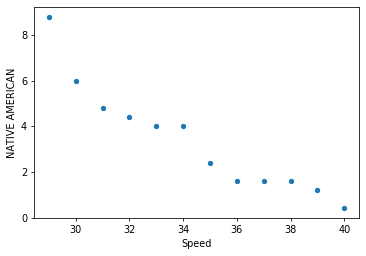

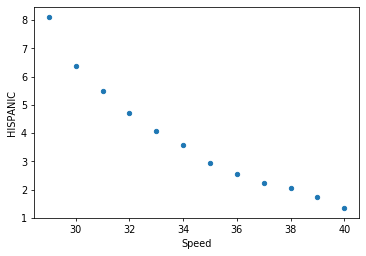

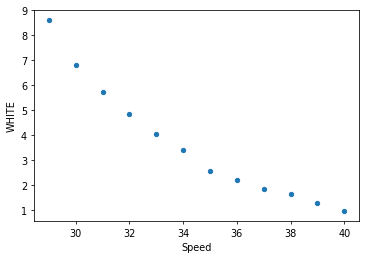

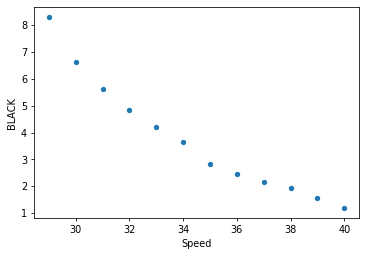

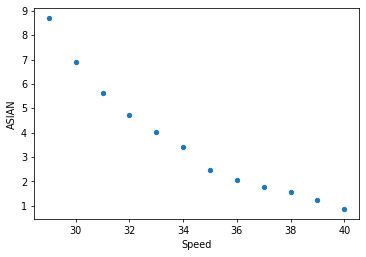

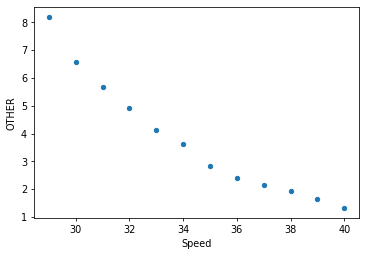

In [16]:
mpl.rcParams['figure.dpi']= 70

ROLLING_MIN_SPEED = 30
ROLLING_MAX_SPEED = 40
rolling_window = ROLLING_WINDOW

rolling_pct_speeds = rolling_percentages_between_a_b_mph(df, ROLLING_MIN_SPEED-rolling_window, ROLLING_MAX_SPEED, rolling_window, None, False)
#(dataframe, a, b, window_arg, min_periods_arg, centered_window_arg)
rolling_pct_speeds['Speed'] = rolling_pct_speeds.index



for col in rolling_pct_speeds:
    if col!='Speed':
        rolling_pct_speeds.plot.scatter(x='Speed', y=col)


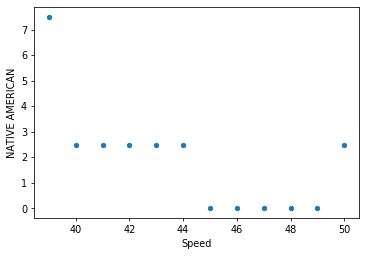

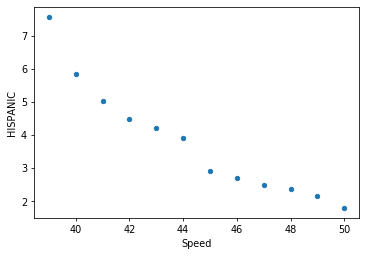

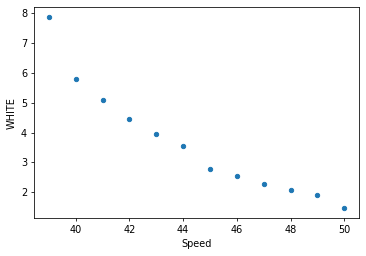

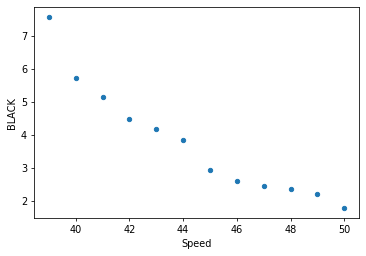

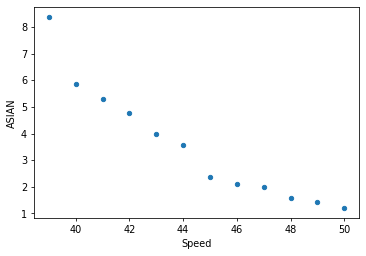

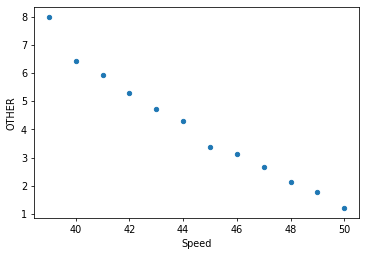

In [17]:
mpl.rcParams['figure.dpi']= 70

ROLLING_MIN_SPEED = 40
ROLLING_MAX_SPEED = 50
rolling_window = ROLLING_WINDOW

rolling_pct_speeds = rolling_percentages_between_a_b_mph(df, ROLLING_MIN_SPEED-rolling_window, ROLLING_MAX_SPEED, rolling_window, None, False)
#(dataframe, a, b, window_arg, min_periods_arg, centered_window_arg)
rolling_pct_speeds['Speed'] = rolling_pct_speeds.index



for col in rolling_pct_speeds:
    if col!='Speed':
        rolling_pct_speeds.plot.scatter(x='Speed', y=col)


### Investigating difference when there's a minimum window

In [18]:
rolling_window = 10
min_window = 5

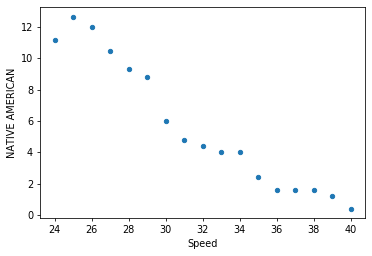

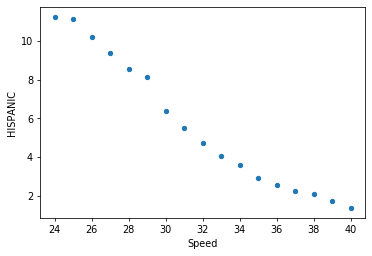

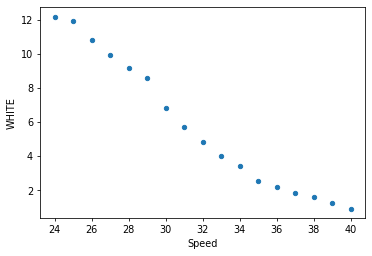

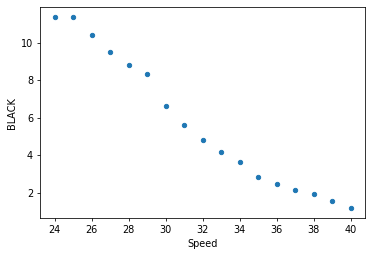

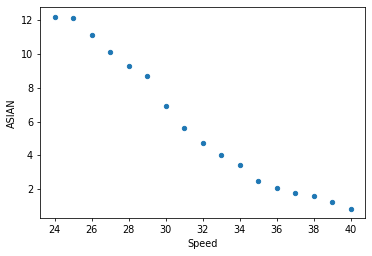

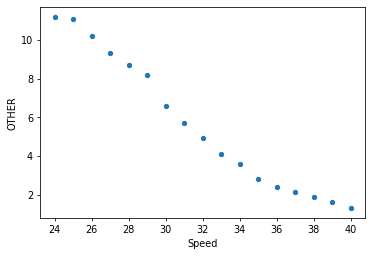

In [19]:
mpl.rcParams['figure.dpi']= 70

ROLLING_MIN_SPEED = 30
ROLLING_MAX_SPEED = 40

rolling_pct_speeds = rolling_percentages_between_a_b_mph(df, ROLLING_MIN_SPEED-rolling_window, ROLLING_MAX_SPEED, rolling_window, min_window, False)
#(dataframe, a, b, window_arg, min_periods_arg, centered_window_arg)

rolling_pct_speeds['Speed'] = rolling_pct_speeds.index



for col in rolling_pct_speeds:
    if col!='Speed':
        rolling_pct_speeds.plot.scatter(x='Speed', y=col)


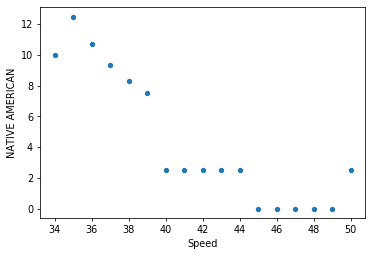

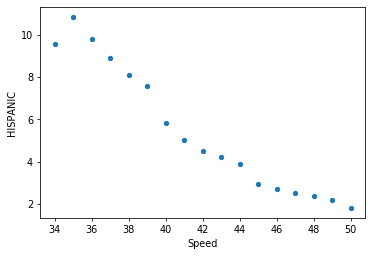

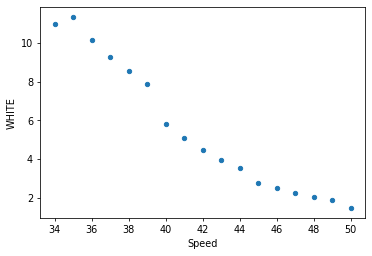

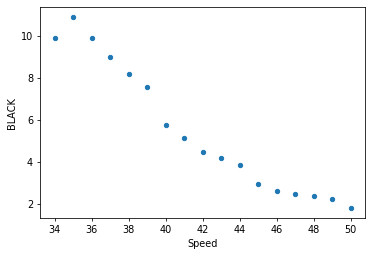

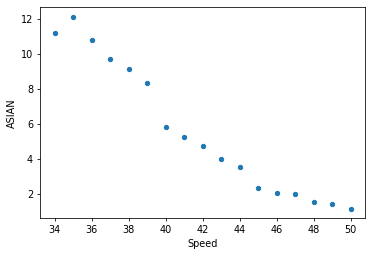

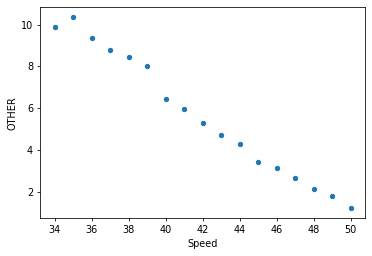

In [20]:
mpl.rcParams['figure.dpi']= 70

ROLLING_MIN_SPEED = 40
ROLLING_MAX_SPEED = 50

rolling_pct_speeds = rolling_percentages_between_a_b_mph(df, ROLLING_MIN_SPEED-rolling_window, ROLLING_MAX_SPEED, rolling_window, min_window, False)
#(dataframe, a, b, window_arg, min_periods_arg, centered_window_arg)

rolling_pct_speeds['Speed'] = rolling_pct_speeds.index



for col in rolling_pct_speeds:
    if col!='Speed':
        rolling_pct_speeds.plot.scatter(x='Speed', y=col)


### Investigating difference with a centered window

It appears that a centered window makes the distribution **less** scale-invariant

In [21]:
rolling_window = 10

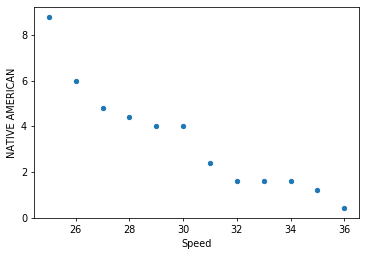

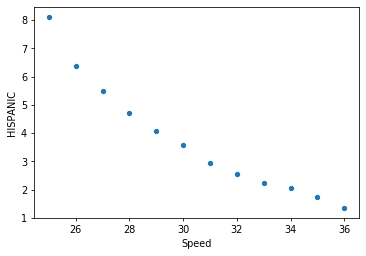

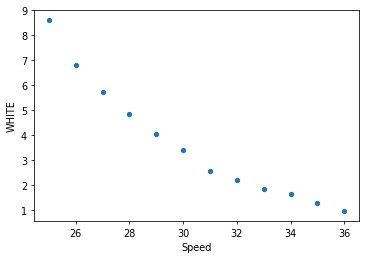

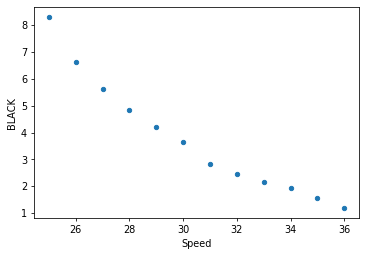

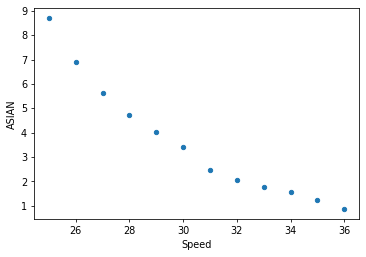

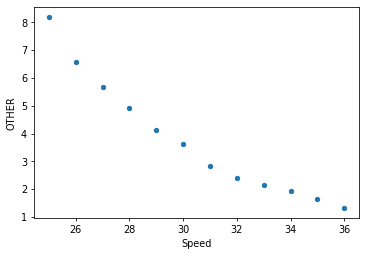

In [22]:
ROLLING_MIN_SPEED = 30
ROLLING_MAX_SPEED = 40

rolling_pct_speeds = rolling_percentages_between_a_b_mph(df, ROLLING_MIN_SPEED-rolling_window, ROLLING_MAX_SPEED, rolling_window, None, True)
#(dataframe, a, b, window_arg, min_periods_arg, centered_window_arg)

rolling_pct_speeds['Speed'] = rolling_pct_speeds.index



for col in rolling_pct_speeds:
    if col!='Speed':
        rolling_pct_speeds.plot.scatter(x='Speed', y=col)


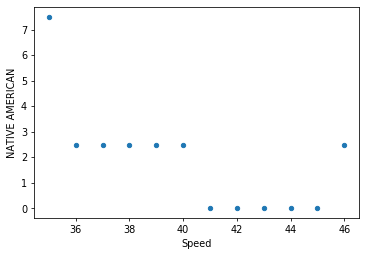

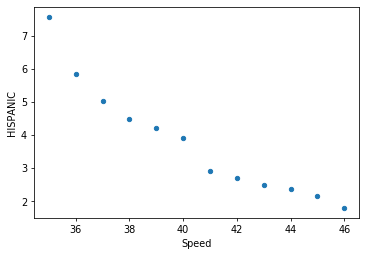

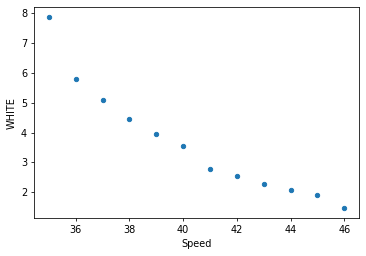

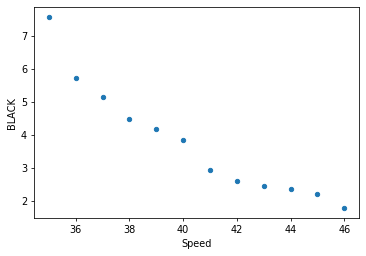

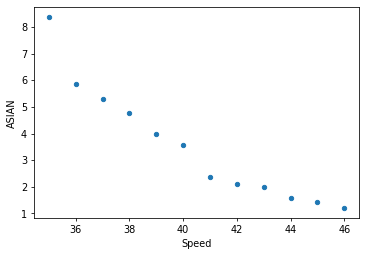

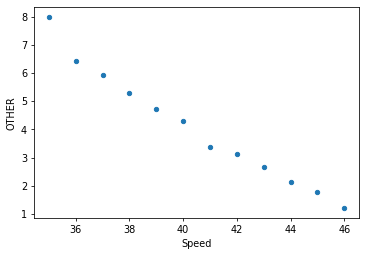

In [23]:
ROLLING_MIN_SPEED = 40
ROLLING_MAX_SPEED = 50

rolling_pct_speeds = rolling_percentages_between_a_b_mph(df, ROLLING_MIN_SPEED-rolling_window, ROLLING_MAX_SPEED, rolling_window, None, True)
#(dataframe, a, b, window_arg, min_periods_arg, centered_window_arg)

rolling_pct_speeds['Speed'] = rolling_pct_speeds.index



for col in rolling_pct_speeds:
    if col!='Speed':
        rolling_pct_speeds.plot.scatter(x='Speed', y=col)


## Next Step - Statistical test 

### Log-Transform Observations

idea: run regression at different log bases until we find the optimal base

In [28]:
rolling_pct_speeds_df = rolling_percentages_between_a_b_mph(df, 10-rolling_window, 100, rolling_window, None, False)

C:\Users\mikha\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


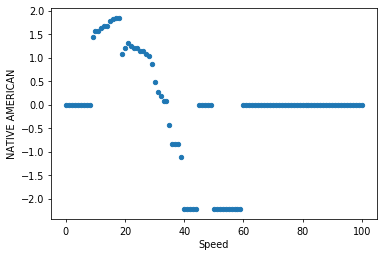

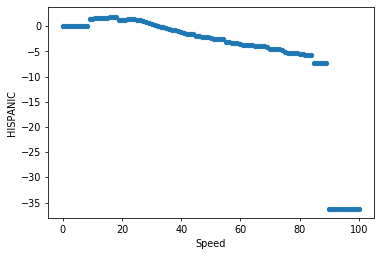

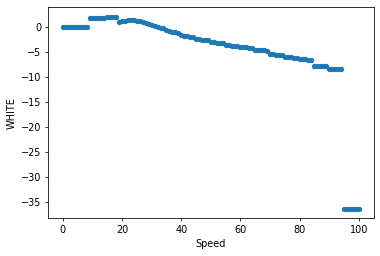

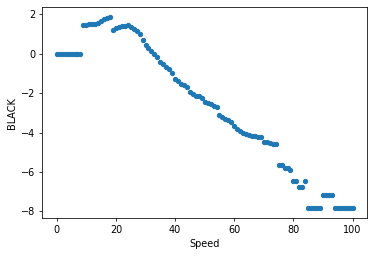

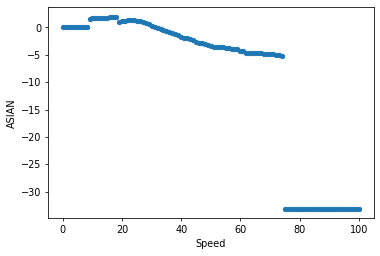

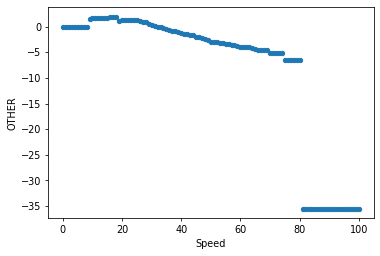

In [29]:
log_rolling_pct_speeds_df = (np.log(rolling_pct_speeds_df)).replace(-np.inf, 0).replace(np.nan, 0) #took logs, replaced -inf, nan values with 0

log_rolling_pct_speeds_df['Speed'] = log_rolling_pct_speeds_df.index #create "Speed" column

for col in log_rolling_pct_speeds_df:
    if col!='Speed':
        log_rolling_pct_speeds_df.plot.scatter(x='Speed', y=col)

In [ ]:
#export to R

log_rolling_pct_speeds_df.to_csv("log power dist export to R.csv", index=False)

In [ ]:
def generate_raw_count_df(dataframe, a, b):
    count_between_a_b_mph_intermediate_dict = {race:{x:0 for x in list(range(a, b+1))} for race in race_set}
    race_total_between_a_b_mph = {race:0 for race in race_set}
    
    #can probably delete this line
    percent_between_a_b_mph_dict = {race:{x:0 for x in list(range(a, b+1))} for race in race_set}

    #raw count of speeds 
    for x in list(zip(dataframe['Speed Over Posted Limit'], dataframe['Race'])):
        if a <= x[0] <= b:
            count_between_a_b_mph_intermediate_dict[x[1]][x[0]] += 1
            race_total_between_a_b_mph[x[1]] += 1
            
    return pd.DataFrame(count_between_a_b_mph_intermediate_dict)

In [ ]:
raw_count_df = generate_raw_count_df(df, 0, 100)
raw_count_df['Speed'] = raw_count_df.index

In [ ]:
for col in raw_count_df:
    if col!='Speed':
        raw_count_df.plot.scatter(x='Speed', y=col)

In [ ]:
def number_obs_finder(dataframe, race, a, b):
    
    return sum(generate_raw_count_df(dataframe, a, b)[race])

In [ ]:
for race in race_set:
    print(race, number_obs_finder(df, race, 30, 4))